In [1]:
%matplotlib inline
import os
import sys
import cv2
import utils
import imageio
import numpy as np
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from collections import Counter
import sys
sys.path.append('./')

In [2]:
# Paths
NUSCENES_LIDAR_DIR = "G:\\intern\\pointcloud\\dataset\\v1.0-mini\\samples\\LIDAR_TOP"
NUSCENES_OUTPUT_DIR = "G:\\intern\\pointcloud\\dataset\\v1.0-mini\\bev\\nuscenes\\samples_uint"
NUSCENES_OUTPUT_DIR_LABEL = "G:\\intern\\pointcloud\\dataset\\v1.0-mini\\bev\\nuscenes\\annotations_uint"
# lidar boundarys for Bird's Eye View
BOUNDARY = {
    "minX": -25,
    "maxX": 25,
    "minY": -25,
    "maxY": 25,
    "minZ": -2.73,
    "maxZ": 1.27
}
BB_BOUNDARY = {
    "minX": -25,
    "maxX": 25,
    "minY": -25,
    "maxY": 25,
}
img_height = 479
img_width = 479
discretization = (BOUNDARY["maxX"] - BOUNDARY["minX"]) / img_height
dataset = "nuscenes"
lidar_path = NUSCENES_LIDAR_DIR
output_dir = NUSCENES_OUTPUT_DIR
output_dir_label = NUSCENES_OUTPUT_DIR_LABEL

In [3]:
def removePoints(PointCloud, BoundaryCond):
    # Boundary condition
    minX = BoundaryCond['minX']
    maxX = BoundaryCond['maxX']
    minY = BoundaryCond['minY']
    maxY = BoundaryCond['maxY']
    minZ = BoundaryCond['minZ']
    maxZ = BoundaryCond['maxZ']

    # Remove the point out of range x,y,z
    mask = np.where(
            (PointCloud[:, 0] >= minX) &
            (PointCloud[:, 0] <= maxX) &
            (PointCloud[:, 1] >= minY) &
            (PointCloud[:, 1] <= maxY) &
            (PointCloud[:, 2] >= minZ) &
            (PointCloud[:, 2] <= maxZ)
            )
    PointCloud = PointCloud[mask]
    PointCloud[:, 2] = PointCloud[:, 2] - minZ
    return PointCloud

def removePoints_bb(PointCloud, BoundaryCond):
    # Boundary condition
    minX = BoundaryCond['minX']
    maxX = BoundaryCond['maxX']
    minY = BoundaryCond['minY']
    maxY = BoundaryCond['maxY']

    # Remove the point out of range x,y,z
    mask = np.where(
            (PointCloud[:, 0] >= minX) &
            (PointCloud[:, 0] <= maxX) &
            (PointCloud[:, 1] >= minY) &
            (PointCloud[:, 1] <= maxY) 
            )
    PointCloud = PointCloud[mask]
    return PointCloud

In [4]:
def makeBVFeature(PointCloud_, BoundaryCond, img_height, img_width, Discretization):
    Height = img_height + 1
    Width = img_width + 1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:, 0] = np.int_(np.floor(PointCloud[:, 0] / Discretization) + Height / 2)
    PointCloud[:, 1] = np.int_(np.floor(PointCloud[:, 1] / Discretization) + Width / 2)
    # sort-3times
    indices = np.lexsort((-PointCloud[:, 2], PointCloud[:, 1], PointCloud[:, 0]))
    PointCloud = PointCloud[indices]

    # Height Map
    heightMap = np.zeros((Height, Width))

    # because of the rounding of points, there are many identical points
    _, indices = np.unique(PointCloud[:, 0:2], axis=0, return_index=True)
    PointCloud_frac = PointCloud[indices]

    # Some important problem is image coordinate is (y,x), not (x,y)
    max_height = float(np.abs(BoundaryCond['maxZ'] - BoundaryCond['minZ']))
    heightMap[np.int_(PointCloud_frac[:, 0]), np.int_(PointCloud_frac[:, 1])] = PointCloud_frac[:, 2] / max_height
    heightMap_normalized = (heightMap - BoundaryCond['minZ'])/abs(BoundaryCond['maxZ']-BoundaryCond['minZ'])  # Normalize to [0, 1]

    return heightMap_normalized 

In [5]:
def project_3dbox(box, BB_BOUNDARY, img_height, img_width, Discretization):
    Height = img_height + 1
    Width = img_width + 1
    corners = box.get_corners(view=np.eye(4))
    corners[:, 0] = -corners[:, 0]
    corners[:, 0] = np.int_(np.floor(corners[:, 0] / Discretization) + Height / 2)
    corners[:, 1] = np.int_(np.floor(corners[:, 1] / Discretization) + Width / 2)
    
    return corners

In [8]:

nusc = NuScenes(version='v1.0-mini', dataroot='../v1.0-mini', verbose=False)
sensor = 'LIDAR_TOP'
for i in range(0,len(nusc.sample)):
    points= nusc.obtain_points(nusc.sample[i]['data'][sensor],axes_limit = 30, underlay_map=False, use_flat_vehicle_coordinates= True)
    data_path, box_list, cam_intrinsic = nusc.get_sample_data(nusc.sample[i]['data'][sensor],use_flat_vehicle_coordinates=True)
    r = R.from_quat([0, 0, np.sin((np.pi / 4)*3), np.cos((np.pi / 4)*3)])
    points[:3, :] = np.dot(r.as_matrix(), points[:3, :])
    lidar_pc = points.T
    print("Processing file (%s|%s)" % (i+1, len(nusc.sample)))
    lidar_pc_filtered = removePoints(lidar_pc, BOUNDARY)
    discretization = (BOUNDARY["maxX"] - BOUNDARY["minX"]) / img_height
    lidar_bev_height = makeBVFeature(lidar_pc_filtered, BOUNDARY, img_height, img_width, discretization)
    lidar_bev_mask = lidar_bev_height > np.min(lidar_bev_height)
    lidar_grey = lidar_bev_mask.astype(int)
    output_filename = 'bv_' + str(i+1) + '.png'
    output_filepath = os.path.join(output_dir, output_filename)
    img_bv = (255*lidar_grey).astype(np.uint8)
    img_bv = np.rot90(img_bv,-1)
    img_bv_rgb = cv2.cvtColor(img_bv, cv2.COLOR_GRAY2RGB)
    cv2.imwrite(output_filepath,img_bv_rgb)
    img = np.zeros([480, 480], np.uint8)
    img[:,:] = 3
#     img = cv2.imread(output_filepath)
    
    for box in box_list: 
        corners = project_3dbox(box, BB_BOUNDARY, img_height, img_width, discretization)
        if "human" in box.name:
            color = 0 #red
        elif "vehicle" in box.name:
            color = 1 #yellow
        elif "movable_object" in box.name:
            color = 2 #blue
        else:
            color = 4 # pink
        res = cv2.fillConvexPoly(img, np.int32([corners]), color)
        img = res
    
    img=np.rot90(img,-1)
#     cv2.imshow('fillpoly', res)
#     output_filename_label = 'merged_' + str(i+1) + '.png'
    output_filename_label = 'label_' + str(i+1) + '.png'
    output_filepath_label = os.path.join(output_dir_label, output_filename_label)
    cv2.imwrite(output_filepath_label,img)
print("\nSuccessfully transformed all '%s' lidar pointclouds" % dataset)

Processing file (1|404)
Processing file (2|404)
Processing file (3|404)
Processing file (4|404)
Processing file (5|404)
Processing file (6|404)
Processing file (7|404)
Processing file (8|404)
Processing file (9|404)
Processing file (10|404)
Processing file (11|404)
Processing file (12|404)
Processing file (13|404)
Processing file (14|404)
Processing file (15|404)
Processing file (16|404)
Processing file (17|404)
Processing file (18|404)
Processing file (19|404)
Processing file (20|404)
Processing file (21|404)
Processing file (22|404)
Processing file (23|404)
Processing file (24|404)
Processing file (25|404)
Processing file (26|404)
Processing file (27|404)
Processing file (28|404)
Processing file (29|404)
Processing file (30|404)
Processing file (31|404)
Processing file (32|404)
Processing file (33|404)
Processing file (34|404)
Processing file (35|404)
Processing file (36|404)
Processing file (37|404)
Processing file (38|404)
Processing file (39|404)
Processing file (40|404)
Processin

Processing file (322|404)
Processing file (323|404)
Processing file (324|404)
Processing file (325|404)
Processing file (326|404)
Processing file (327|404)
Processing file (328|404)
Processing file (329|404)
Processing file (330|404)
Processing file (331|404)
Processing file (332|404)
Processing file (333|404)
Processing file (334|404)
Processing file (335|404)
Processing file (336|404)
Processing file (337|404)
Processing file (338|404)
Processing file (339|404)
Processing file (340|404)
Processing file (341|404)
Processing file (342|404)
Processing file (343|404)
Processing file (344|404)
Processing file (345|404)
Processing file (346|404)
Processing file (347|404)
Processing file (348|404)
Processing file (349|404)
Processing file (350|404)
Processing file (351|404)
Processing file (352|404)
Processing file (353|404)
Processing file (354|404)
Processing file (355|404)
Processing file (356|404)
Processing file (357|404)
Processing file (358|404)
Processing file (359|404)
Processing f

In [13]:
color_encoding = {0: (255, 0, 0),
      1: (255, 255, 0),
      2: (0, 0, 255),
      3: (0, 255, 0),
      4: (255, 0, 255)}

def label_to_rgb(label, colormap = color_encoding):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    output = np.zeros(label.shape[:2]+(3,))
    for k in colormap.keys():
        output[label==k] = colormap[k]
    return np.uint8(output)

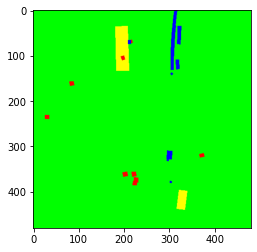

In [17]:
file = "G:\\intern\\pointcloud\\dataset\\v1.0-mini\\bev\\nuscenes\\annotations_uint\\label_1.png"
img = cv2.imread(file,cv2.IMREAD_UNCHANGED)
img = label_to_rgb(img, colormap = color_encoding)
plt.imshow(img)